# Operation IceBridge SnowRadar (2-8 GHz) Example

Example of using wavelet picker with CRESIS 2-8 GHz snow radar data (MATFILE)

In [1]:
#pySnowRadar modules
from pySnowRadar import SnowRadar
from pySnowRadar.processing import extract_layers
from pySnowRadar.algorithms import Wavelet_TN, Peakiness

# from msc_thesis_functions import *
# del sys.modules['msc_thesis_functions']
# from msc_thesis_functions import *
#Community packages
import os
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
from datetime import datetime, timedelta
from thefuzz import process, fuzz
from scipy.spatial.distance import cdist
from tqdm import tqdm
import h5py



In [2]:
def open_data(path, filetype, mode, instrument):
    if mode == 'dict':
        df_dict = {}
        if filetype == 'csv' or filetype=='txt':
            if instrument == 'MP':
                lon_col = detect_cols(path, keywords=['lon','Longitude'])
                lat_col = detect_cols(path, keywords=['lat', 'Latitude'])
                time_col = detect_cols(path, keywords=['timestamp', 'datetime'])
                var_col = detect_cols(path, keywords=['snow_depth', 'MagnaProbe','depth'])
                site_col = detect_cols(path, keywords=['site','site_id'])
                type_col = detect_cols(path, keywords=['type','ice_type'])

                cols = []
                cols.append(lon_col) if lon_col != None else None
                cols.append(lat_col) if lat_col != None else None
                cols.append(time_col) if time_col != None else None
                cols.append(var_col) if var_col != None else None
                cols.append(site_col) if site_col != None else None
                cols.append(type_col) if type_col != None else None

                names = []
                names.append('lon') if lon_col != None else None
                names.append('lat') if lat_col != None else None
                names.append('time') if time_col != None else None
                names.append('snow_depth') if var_col != None else None
                names.append("site_id") if site_col != None else None
                names.append("ice_type") if type_col != None else None

                df_import = pd.DataFrame({'names':names}, index=cols)

                df_import.sort_index(inplace=True)
                df = pd.read_csv(path, skiprows=1,  usecols=list(df_import.index), names=df_import['names'])
                if np.mean(df['snow_depth'] > 5): #convert [cm] to [m] in snowdepth
                    df['snow_depth'] /= 100
                df.loc[df['lon'] < 0, 'lon'] += 360
                
                df = strtime_to_datetime(df)
                
                if site_col != None:
                    df_dict = split_data(df, df_dict)
                    
                else:
                    df_dict['1'] = df

        elif filetype == 'h5':
            #This could (should) be more flexible to detect data fields etc.
            #Since we only (atm) use 1 h5 file, it is tailored for this file
            f = h5py.File(path, 'r')
            group = f['eureka_data']
            data = group['magnaprobe']
            df = pd.DataFrame({'lat':data['latitude'][()], 'lon':data['longitude'][()], 'snow_depth':data['snow_depth'][()], 'site_id':data['site_id'][()]})
            df.loc[df['lon'] < 0, 'lon'] += 360
            df_dict = split_data(df, df_dict)

        return df_dict

    elif mode == 'df':
        
        if filetype == 'csv' or filetype=='txt':
            if instrument == 'OIB':
                df = pd.read_csv(path, usecols=[0,1,2,7,8,15,16])
                df['date'] = df['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
                df['datetime'] = df['date'] + df['elapsed'].apply(lambda x: timedelta(seconds=x))
                df = df[df['snow_depth'] != -99999]
                del df['date'], df['elapsed']
                
            elif instrument == 'ATM':
                df = pd.read_csv(path, index_col=0)
                
        return df

def strtime_to_datetime(df):
    try:
        df['time'] = df['time'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M') )
        
    except:
        df['time'] = clean_time_col(df['time'])
        df['time'] = df['time'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M') )

    return df 

def clean_time_col(time): 
    weird_indices = time.apply(lambda x: len(x) > 16) #length of weird timestamps is higher
    time.loc[weird_indices] = np.nan
    time = time.ffill()
    return time
 
def get_extent_latlon(lon, lat):
    '''
    Calculates the extent of a given list of latlon coordinates. 
    Jumps from 360 deg to 0 deg (or visce versa) in longitude are handled.

    Inputs:
    lon: List of longitude coordinates
    lat: List of latitude coordinates

    Returns:
    extent_latlon: Four point tuple containing the extent: (x0, y0, x1, y2)
    '''
    
    minlat = min(lat)
    maxlat = max(lat)
    minlon = min(lon)
    maxlon = max(lon)

    diff_lon = np.diff(lon)

    if max(abs(diff_lon)) > 100: #find discontinuity in lon
        indices_max,_ = find_peaks(diff_lon, height= 200)
        indices_min,_ = find_peaks(diff_lon*-1, height= 200)
        indices = sorted(np.append(indices_max, [x for x in indices_min]))
        indices.append(len(diff_lon)) 

        offset = np.ones_like(indices)

        if indices[0] in indices_max:
            indices.insert(0,0)
            offset = np.insert(offset,0,0)

        tmp_lon = lon.copy()
        for i in range(0,len(indices)-1,2):
            ind1 = indices[i] + offset[i]
            ind2 = indices[i+1] + 1
            tmp_lon[ind1:ind2] = tmp_lon.iloc[ind1:ind2] + 360
            
        minlon = min(tmp_lon)
        if minlon > 360:
            minlon -= 360
        maxlon = max(tmp_lon)
        if maxlon > 360:
            maxlon -= 360

    extent_latlon = (minlon, minlat, maxlon, maxlat)
    return extent_latlon

def ordering_latlon(df):
    bounds = get_extent_latlon(df['lon'],df['lat'])
    idx = df.loc[(df['lat'] == bounds[1])].index[0]

    reind = np.arange(0,len(df))
    reind = np.delete(reind, idx)
    reind = np.insert(reind, 0, idx)
    df = df.reindex(reind)
    df.reset_index(inplace=True, drop=True)

    dists = cdist(list(zip(df['lon'],df['lat'])),list(zip(df['lon'],df['lat'])))
    mask = np.zeros(len(df['lon'])).astype(bool)
    tst = []
    i = 0
    for j in range(len(mask)-1):
        mask[i] = True
        dist_zero = dists[0,:]
        dist_zero[mask] = np.nan
        row = dists[:,i].copy() + dist_zero
        i = np.nanargmin(row)
        tst.append(i)
    df = df.loc[tst]
    df.reset_index(inplace=True, drop=True)
    return df

def split_data(df, df_dict):
    for uniq in df['site_id'].unique():
        df_tmp = df[df['site_id'] == uniq]
        if len(df_tmp) > 10000:
            df_tmp = ordering_latlon(df_tmp)
            df_tmp.dropna(inplace=True)

            num_steps = int(np.ceil(len(df_tmp) / 3000))
            steps = np.linspace(0,len(df_tmp), num_steps).astype(int)
            for i in range(len(steps)-1):
                df_tmp_part = df_tmp.loc[steps[i]:steps[i+1]]
                df_dict[f'{uniq}.{i}'] = df_tmp_part

        else:
            df_dict[str(uniq)] = df_tmp

    return df_dict   

def detect_cols(path, keywords):

    df_test = pd.read_csv(path)
    cols = list(df_test.columns)
    scores = np.zeros(len(cols),dtype='int')
    df_scores = pd.DataFrame({'scores':scores},index=cols)
    dt = np.dtype(np.str_,np.int_)

    for key in keywords:
        fuzzy = process.extract(key, cols, limit=len(cols)) 
        inds = np.array(fuzzy,dtype=dt)[:,0]
        scrs = pd.Series(np.array(fuzzy,dtype=dt)[:,1].astype(int), index=inds)
        df_scores['scores'] += scrs

        if True in (scrs > 80).unique():
            tst = df_scores.reset_index()
            col_ind = tst[tst['index'] == (scrs > 80).index[0]].index[0]
            return col_ind

    col_ind = df_scores['scores'].argmax() if df_scores['scores'].max() > len(keywords) * 65 else None
    return col_ind

In [2]:
extent = (272.3, 79.85, 274, 80.05) #minlon, minlat, maxlon, maxlat for EUREKA 2014

year = '2016'
campaign = 'EUREKA2016'
sites = ['grid1', 'grid2', 'grid3', 'grid4', 'grid5', 'grid6', 'grid7', 'grid8']


In [4]:
# alternatively load MP insitu

path_MP= '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/ECCC_2016_Eureka_Magnaprobe.csv' #EUREKA 2016
filetype = path_MP.split('.')[1]
MP_data_dict = open_data(path_MP, filetype=filetype, mode='dict', instrument='MP')

for site in sites:
    if site == 'grid1':
        df_df = MP_data_dict[site]
    else:
        df_df = pd.concat([df_df, MP_data_dict[site]])     
           
df_df['site'] = df_df['site_id']
df_df['ice_age'] = df_df['site'].apply(lambda x: 'myi' if x=='grid8' or x=='grid5' else 'fyi')
df_df.reset_index(inplace=True, drop=True)

/var/folders/33/mb4rwg392ds1fw9l8rx1tnp80000gn/T/ipykernel_4284/2259196774.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time.loc[weird_indices] = np.nan


In [5]:
# load ATM (ungridded)
outer_path = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/ATM/2016'

folders = os.listdir(outer_path)
folders = [x for x in folders if x != '.DS_Store' and 'csv' not in x and 'gridded_data_old' not in x]
i = 0
for folder in tqdm(folders):
    inner_path = os.path.join(outer_path, folder)
    h5file = [x for x in os.listdir(inner_path) if x.split('.')[-1] == 'h5'][0]
    if year in h5file:
        f = h5py.File(os.path.join(inner_path, h5file), 'r')
        elev = f['elevation']
        lon = f['longitude']
        lat = f['latitude']
        time = f['instrument_parameters']['time_hhmmss']
        # time_formatted =  [datetime.combine(datetime(2016,4,19), datetime.strptime(f'{x:.3f}', '%H%M%S.%f').time()) for x in time]
        if i == 0:
            df_ATM = pd.DataFrame({'time':time, 'lon':lon, 'lat':lat, 'elev':elev})
        else:
            df = pd.DataFrame({'time':time, 'lon':lon, 'lat':lat, 'elev':elev})
            
            df_ATM = pd.concat([df_ATM, df])
            
        i+=1
        
df_ATM.reset_index(inplace=True, drop=True)
df_ATM = df_ATM.loc[(df_ATM['lon'] > extent[0]) & (df_ATM['lon'] < extent[2])].loc[(df_ATM['lat'] > extent[1]) & (df_ATM['lat'] < extent[3])]
df_ATM.reset_index(inplace=True, drop=True) 

# subset ATM to in situ sites
df_ATM_dict = {}
for site in tqdm(sites):
    extent_tmp = get_extent_latlon(MP_data_dict[site]['lon'],MP_data_dict[site]['lat'])
    if site == sites[0]:
        df_tmp = df_ATM.loc[(df_ATM['lon'] > extent_tmp[0]) & (df_ATM['lon'] < extent_tmp[2])].loc[(df_ATM['lat'] > extent_tmp[1]) & (df_ATM['lat'] < extent_tmp[3])]
        df_tmp['site'] = [site] * len(df_tmp)
        df_ATM_dict[site] = df_tmp
        
    else:
        df_tmp2 = df_ATM.loc[(df_ATM['lon'] > extent_tmp[0]) & (df_ATM['lon'] < extent_tmp[2])].loc[(df_ATM['lat'] > extent_tmp[1]) & (df_ATM['lat'] < extent_tmp[3])]
        df_tmp2['site'] = [site] * len(df_tmp2)
        df_ATM_dict[site] = df_tmp2
        
        df_tmp = pd.concat([df_tmp, df_tmp2])
    
df_ATM = df_tmp.copy()

df_ATM.drop_duplicates(inplace=True)
df_ATM.dropna(inplace=True)
df_ATM.reset_index(drop=True, inplace=True)
df_ATM['time'] = df_ATM['time'].apply(lambda x: datetime.combine(datetime(2016,4,19), datetime.strptime(f'{x:.3f}', '%H%M%S.%f').time()))

# df_ATM = df_wavelet[df_wavelet['snow_depth'] != 0]
# df_wavelet['ice_age'] = df_wavelet['site'].apply(lambda x: 'myi' if x=='grid8' or x=='grid5' else 'fyi')


  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:01<00:00,  5.63it/s]


In [2]:
radar_file = "/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/Echograms/20160419/116460490/IRSNO1B_20160419_04_082_deconv.nc"
radar_dat = SnowRadar(radar_file, l_case='full')
time_min = radar_dat.time_utc.min()
time_max = radar_dat.time_utc.max()

# df_ATM_subset = df_ATM.loc[(df_ATM['time'] > time_min) & (df_ATM['time'] < time_max)]

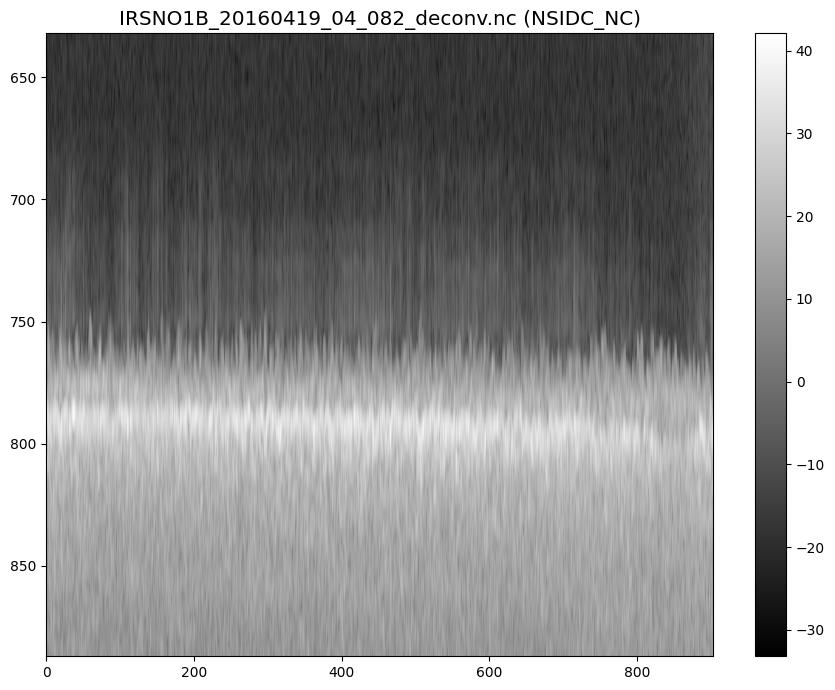

In [3]:
# Find surface and trim data
radar_dat.surf_bin, radar_dat.surface = radar_dat.get_surface()
radar_bounds = radar_dat.get_bounds(2,1)
radar_dat.plot_quicklook(ylim = list(radar_bounds))

## Application of wavelet picker

In [4]:
# Set up picker parameters and extract interfaces using the Newman wavelet

#these are the input parameters from Fredensborg-Hansen (2024), "Exploring [...]" for Antarctic summer sea ice/ snow

# params={'snow_density':0.3,
#         'log_peak_threshold' : 0.6,
#         'lin_peak_threshold' : 0.2, 
#         'pp_r_threshold' : 20, 
#         'pp_l_threshold' : 20
#         }

params={'snow_density':0.3,
        'ref_snow_layer': 1,
        'cwt_precision': 10}

res_TN = extract_layers(radar_file, picker=Wavelet_TN, params=params, dump_results=False)

(1271, 904)
(1271, 904)


In [71]:
C = 299792458 # Vacuum speed of light

elevation_axis = []
for elev in radar_dat.elevation:
    elevation_axis.append(elev - radar_dat.time_fast * C / 2)

<xarray.Dataset>
Dimensions:               (range_bin: 1271, time: 904)
Coordinates:
  * time                  (time) datetime64[ns] 2016-04-19T13:55:57 ... 2016-...
  * range_bin             (range_bin) int64 0 1 2 3 4 ... 1267 1268 1269 1270
    elevation_axis        (range_bin) float64 15.8 15.78 15.77 ... -0.669 -0.682
    along_track_distance  (time) float64 0.0 5.469 10.94 ... 4.968e+03 4.973e+03
    lon                   (time) float64 -86.8 -86.8 -86.8 ... -86.8 -86.8 -86.8
    lat                   (time) float64 79.9 79.9 79.9 ... 79.85 79.85 79.85
Data variables: (12/14)
    radar_data            (range_bin, time) float32 0.01384 0.02292 ... 3.256
    pulse_peakiness       (time) float32 0.001805 0.002341 ... 0.0009552
    altitude              (time) float64 515.6 515.6 515.6 ... 515.6 515.6 515.6
    roll                  (time) float64 -0.231 -0.2263 ... -0.01073 0.02361
    pitch                 (time) float64 0.7549 0.7522 0.7494 ... 0.7183 0.7153
    wavelet_coefs_log     (time) float64 nan nan nan nan nan ... nan nan nan nan
    ...                    ...
    snow_ice_index        (time) float64 nan nan nan nan nan ... nan nan nan nan
    air_snow_distance     (time) float64 nan nan nan nan nan ... nan nan nan nan
    snow_ice_distance     (time) float64 nan nan nan nan nan ... nan nan nan nan
    air_snow_elevation    (time) float64 nan nan nan nan nan ... nan nan nan nan
    snow_ice_elevation    (time) float64 nan nan nan nan nan ... nan nan nan nan
    snow_depth            (time) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    radar_name:             snow3
    src:                    IRSNO1B_20160419_04_082_deconv.nc
    picker:                 Wavelet_TN
    n_snow:                 1.238066467117174
    null_2_space:           0.19986163866666665
    delta_fast_time_range:  0.012975781596299215

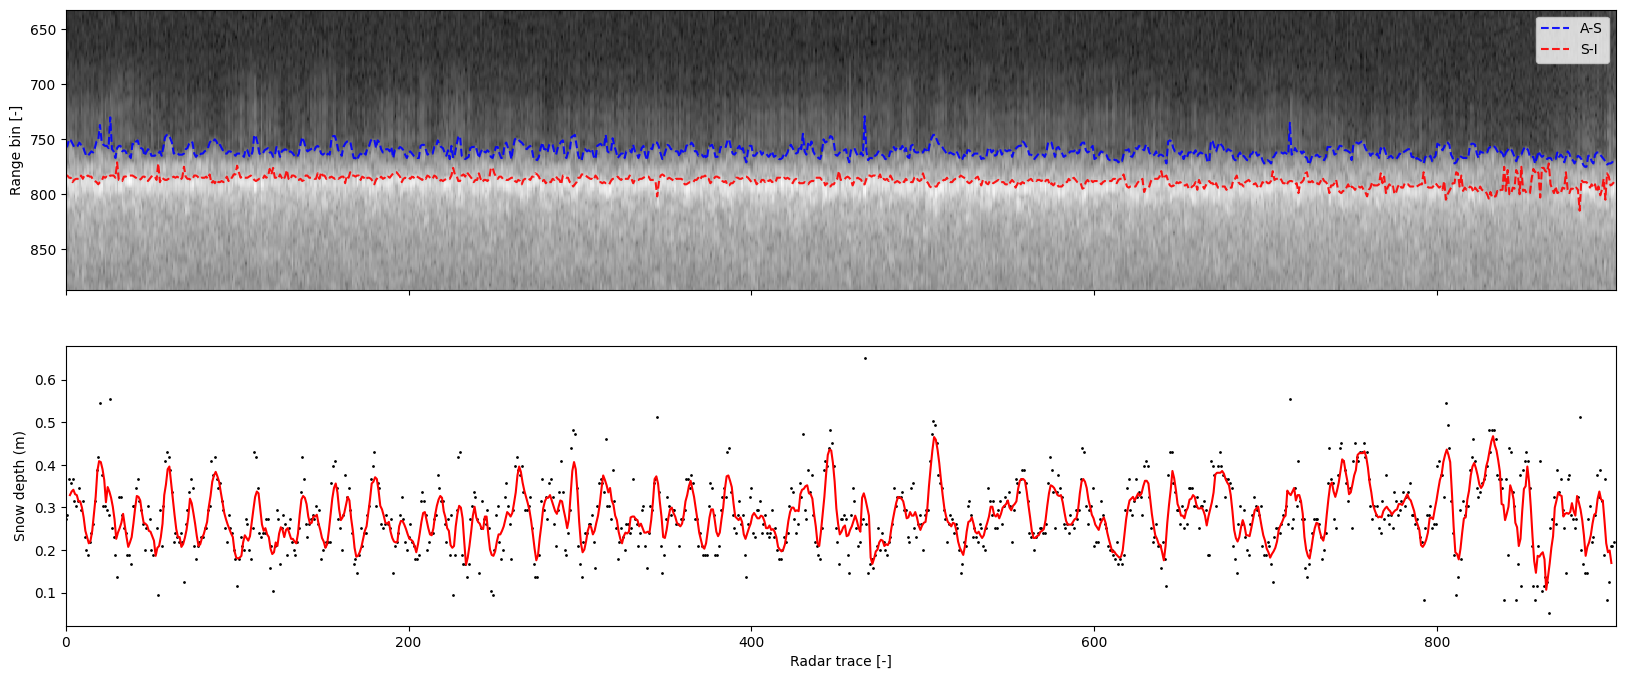

In [12]:
# Plot interface picks and snow depth
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,8), sharex=True)
ax1.imshow(10 * np.log10(radar_dat.data_radar/np.nanmax(radar_dat.data_radar)), interpolation='none', cmap="gist_gray",  aspect='auto')
ax1.plot(res_TN['air_snow_index'], linestyle='--', color='b',alpha=0.9,label='A-S')
ax1.plot(res_TN['snow_ice_index'], linestyle='--', color='r',alpha=0.9,label='S-I')
ax1.legend(loc="upper right")


# Rolling average of depth over 5 bins
N = 5
snow_depth_rolling = np.convolve(res_TN['snow_depth'], np.ones((N,))/N, mode='valid')
estart = N/2
eend = len(snow_depth_rolling)+(N/2)

ax2.scatter(np.arange(0,len(res_TN['snow_depth'])), res_TN['snow_depth'], color = 'k', s = 1)
ax2.plot(np.arange(estart, eend),snow_depth_rolling, color='r')


ax1.set_ylim(radar_bounds)
ax2.set_xlim(0, len(res_TN['snow_depth']))
ax1.set_ylabel("Range bin [-]")
ax2.set_ylabel("Snow depth (m)")
ax2.set_xlabel("Radar trace [-]");

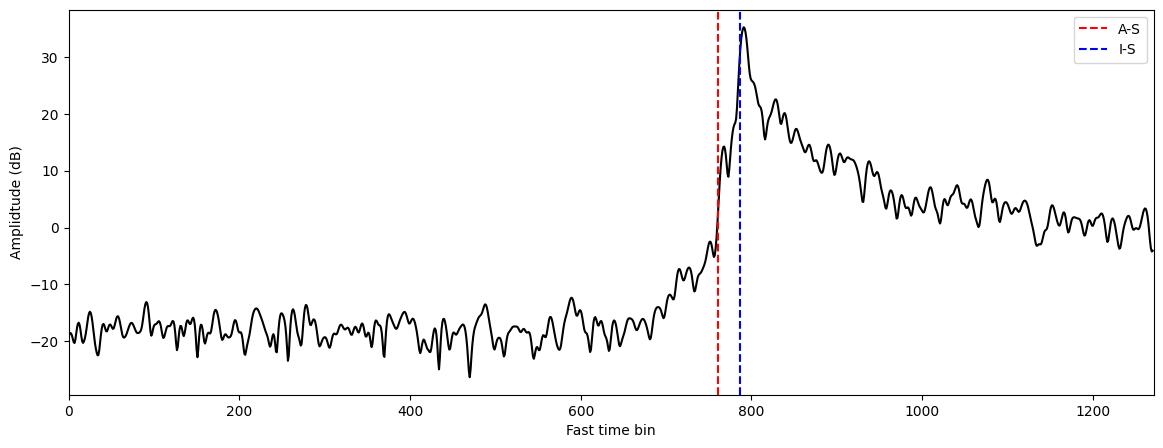

In [14]:
col_idx = np.random.randint(0,radar_dat.data_radar.shape[1])
fig, ax = plt.subplots(figsize=(14,5))




with np.errstate(divide='ignore'):
    ax.plot(10*np.log10(radar_dat.data_radar[:,col_idx]), color = 'k', label=None)

# Air-Snow picked interface
ax.vlines(res_TN['air_snow_index'][col_idx], 0, 1, label='A-S', linestyles='dashed', transform=ax.get_xaxis_transform(), color='r')
# Snow-Ice picked interface
ax.vlines(res_TN['snow_ice_index'][col_idx], 0, 1, label='I-S', linestyles='dashed', transform=ax.get_xaxis_transform(), color='b')

ax.set_xlim(0, len(radar_dat.data_radar[:,col_idx]))
ax.set_xlabel("Fast time bin")
ax.set_ylabel("Amplidtude (dB)")
ax.legend(loc="upper right");